In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
# pd.set_option("display.max_rows", None)

In [37]:
def clean_csv(main_df: pd.DataFrame) -> list[(str, pd.DataFrame)]:
    data_list = []
    main_df.rename(columns={"REMOVAL_DATE": "FULL_REMOVAL_DATE"}, inplace=True)
    main_df["REMOVAL_DATE"] = main_df["FULL_REMOVAL_DATE"].apply(lambda x: str(x)[:10])
    main_df["REMOVAL_TIME"] = main_df["FULL_REMOVAL_DATE"].apply(lambda x: str(x)[11:-4])
    main_df.dropna(subset=["FULL_REMOVAL_DATE"], inplace=True)
    main_df["REMOVAL_TIME"] = main_df["REMOVAL_TIME"].apply(lambda x: datetime.strptime(x, "%H:%M"))
    main_df["REMOVAL_TIME"] = main_df["REMOVAL_TIME"].apply(lambda x: x + timedelta(hours=10))
    main_df["REMOVAL_TIME"] = main_df["REMOVAL_TIME"].apply(lambda x: x.strftime("%H:%M"))
    
    Greyhounds = main_df.loc[main_df["RACING_TYPE"] == "Greyhounds"]
    Thoroughbred = main_df.loc[main_df["RACING_TYPE"] == "Thoroughbred"]
    Harness = main_df.loc[main_df["RACING_TYPE"] == "Harness"]

    data_list.append(("main", main_df))
    data_list.append(("Greyhounds", Greyhounds))
    data_list.append(("Thoroughbred", Thoroughbred))
    data_list.append(("Harness", Harness))
    
    return data_list




In [82]:
def graph(aggregate_interval: pd.DataFrame, name: str, time_interval: str):
    plt.figure(facecolor="black", figsize=(25,6))
    ax = plt.axes(facecolor="black") 
    plt.xlabel("Time", color="white")
    plt.ylabel("Volume", color="white")
    ax.spines["right"].set_color("white")
    ax.spines["left"].set_color("white")
    ax.spines["top"].set_color("white")
    ax.spines["bottom"].set_color("white")
    ax.tick_params(axis="x", colors="white") 
    ax.tick_params(axis="y", colors="white")
    if time_interval == "all":
        plt.xticks(np.arange(0, len(aggregate_interval["REMOVAL_TIME"]), 60), rotation=20)
    elif time_interval == "15m":
        plt.xticks(np.arange(0, len(aggregate_interval["REMOVAL_TIME"]), 4), rotation=20)
        
    plt.title(name, fontsize=16, fontweight="bold", color="yellow")
    plt.bar(aggregate_interval["REMOVAL_TIME"], aggregate_interval["Volume"])


In [84]:
def main(csv, time_interval):
    df = pd.read_csv(csv)
    data_list = []
    assert time_interval in ["all", "15m", "1h"] , "time intervals can be 'all' (aggregate per min) '15m' (aggregate per 15 min) or '1h' (aggregate per hour)"
    # creates a empty timeline based on given time interval
    time_all_mins = pd.date_range(start='00:00:00', end='23:59:00', freq='1T').time
    time_15_mins = pd.date_range(start='00:00:00', end='23:59:00', freq='15T').time 
    time_1h_mins = pd.date_range(start='00:00:00', end='23:59:00', freq='60T').time

    if time_interval == "all":
        time_interval_df = time_all_mins
    elif time_interval == "15m":
        time_interval_df = time_15_mins
    elif time_interval == "1h":
        time_interval_df = time_1h_mins 


    #defines timeline axis
    all_mins = [time.strftime('%H:%M') for time in time_all_mins]
    all_mins_df = pd.DataFrame({'REMOVAL_TIME': all_mins})

    #defines x axis
    x_labels = [time.strftime('%H:%M') for time in time_interval_df]
    x_label_df = pd.DataFrame({'REMOVAL_TIME': x_labels})


    data_list = clean_csv(df)
    
    # prints out graphs for all the different races
    for race_type in data_list:
        name = race_type[0]
        df = race_type[1]

        per_min = df.groupby("REMOVAL_TIME").size().reset_index(name="Volume")
        data_full = pd.merge(all_mins_df, per_min, on="REMOVAL_TIME", how="left")
        data_full.fillna(0, inplace=True)

        per_15m = data_full.groupby(data_full.index // 15)["Volume"].sum()
        per_1h = data_full.groupby(data_full.index // 60)["Volume"].sum()

        if time_interval == "all":
            aggregate_interval_df = data_full
        elif time_interval == "15m":
            data_15m = pd.merge(x_label_df, per_15m, left_index=True, right_index=True, how="left")
            aggregate_interval_df = data_15m
        elif time_interval == "1h":
            data_1h = pd.merge(x_label_df, per_1h, left_index=True, right_index=True, how="left")
            aggregate_interval_df = data_1h

        graph(aggregate_interval_df, name, time_interval)


C:\Users\mplx3\AppData\Local\Temp\ipykernel_27152\875397910.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv)


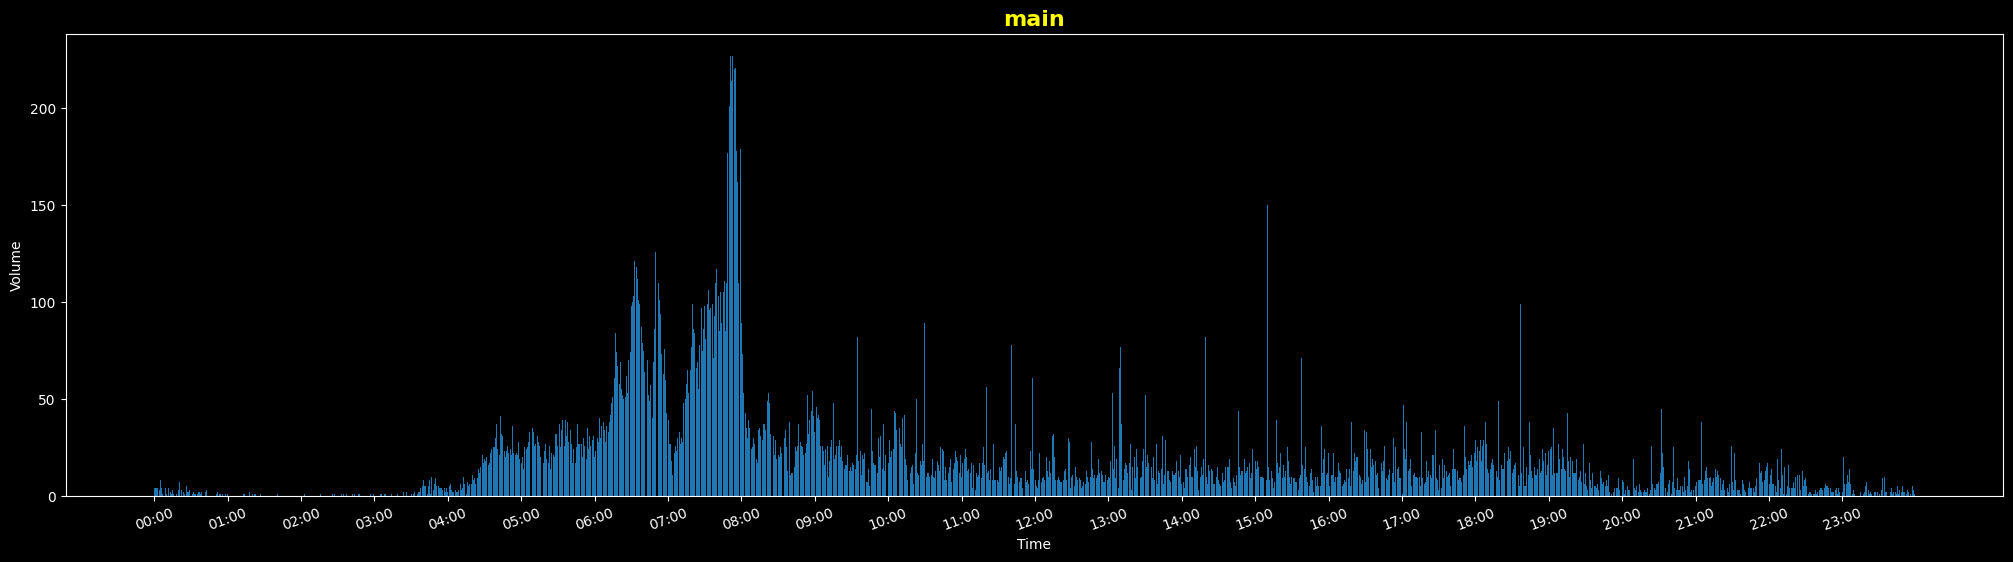

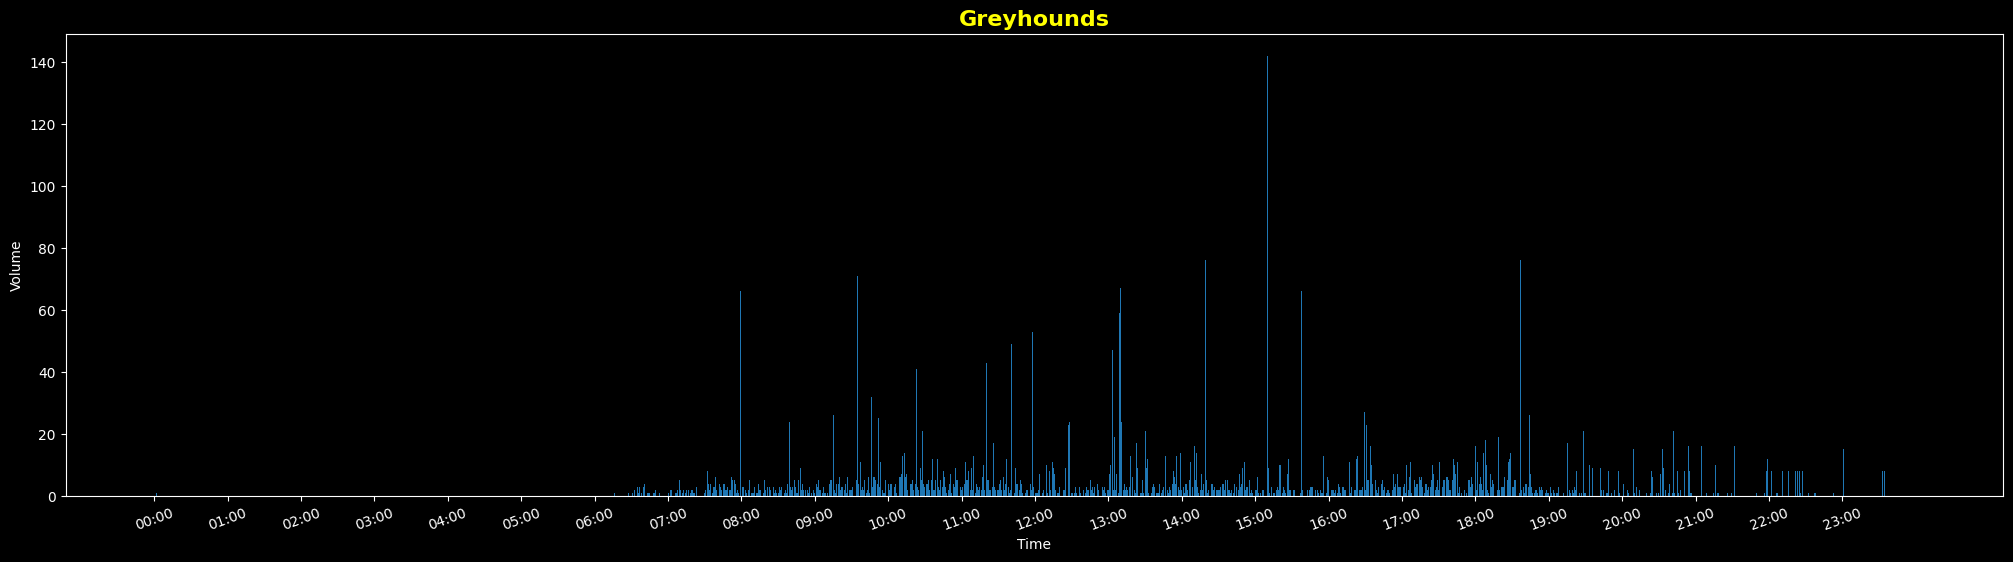

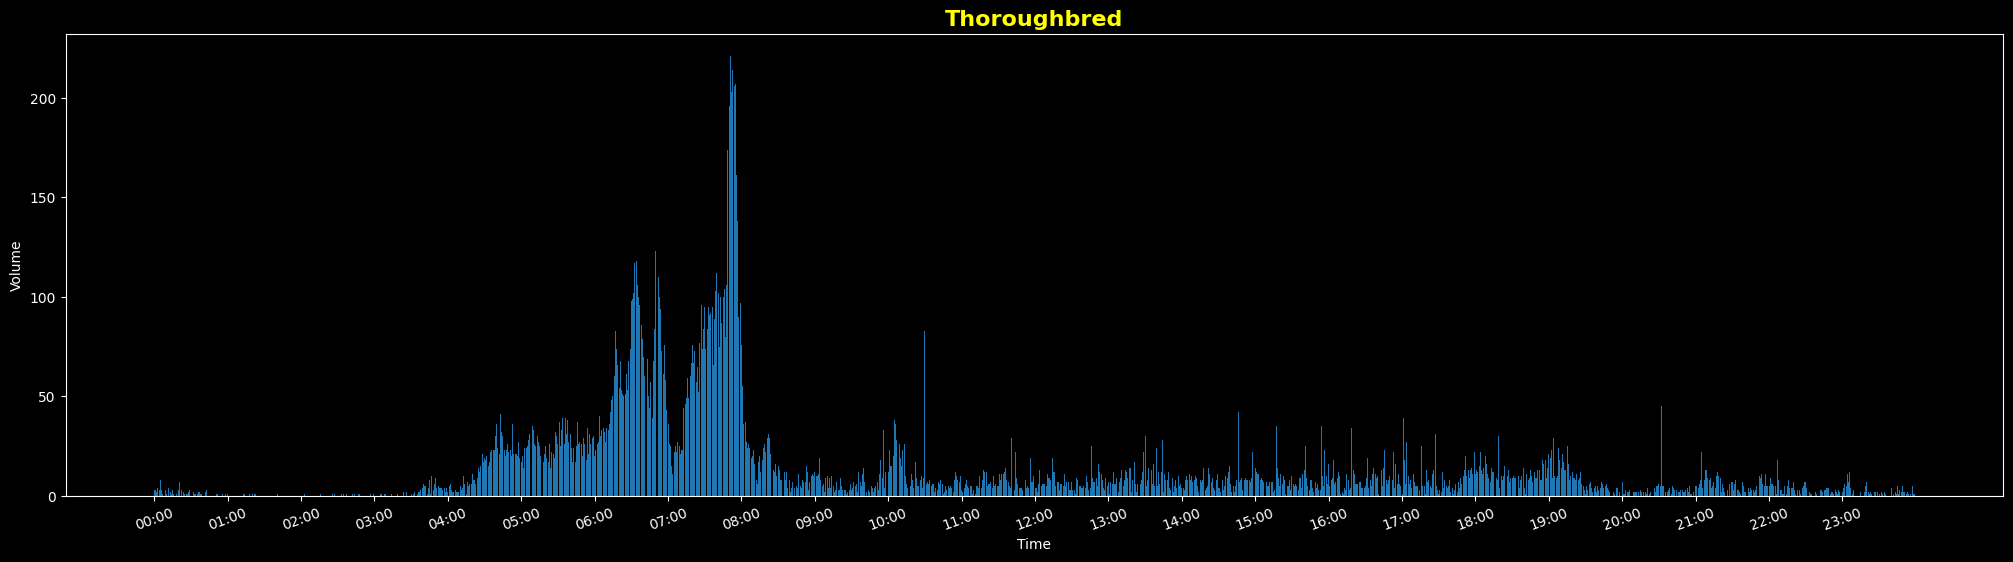

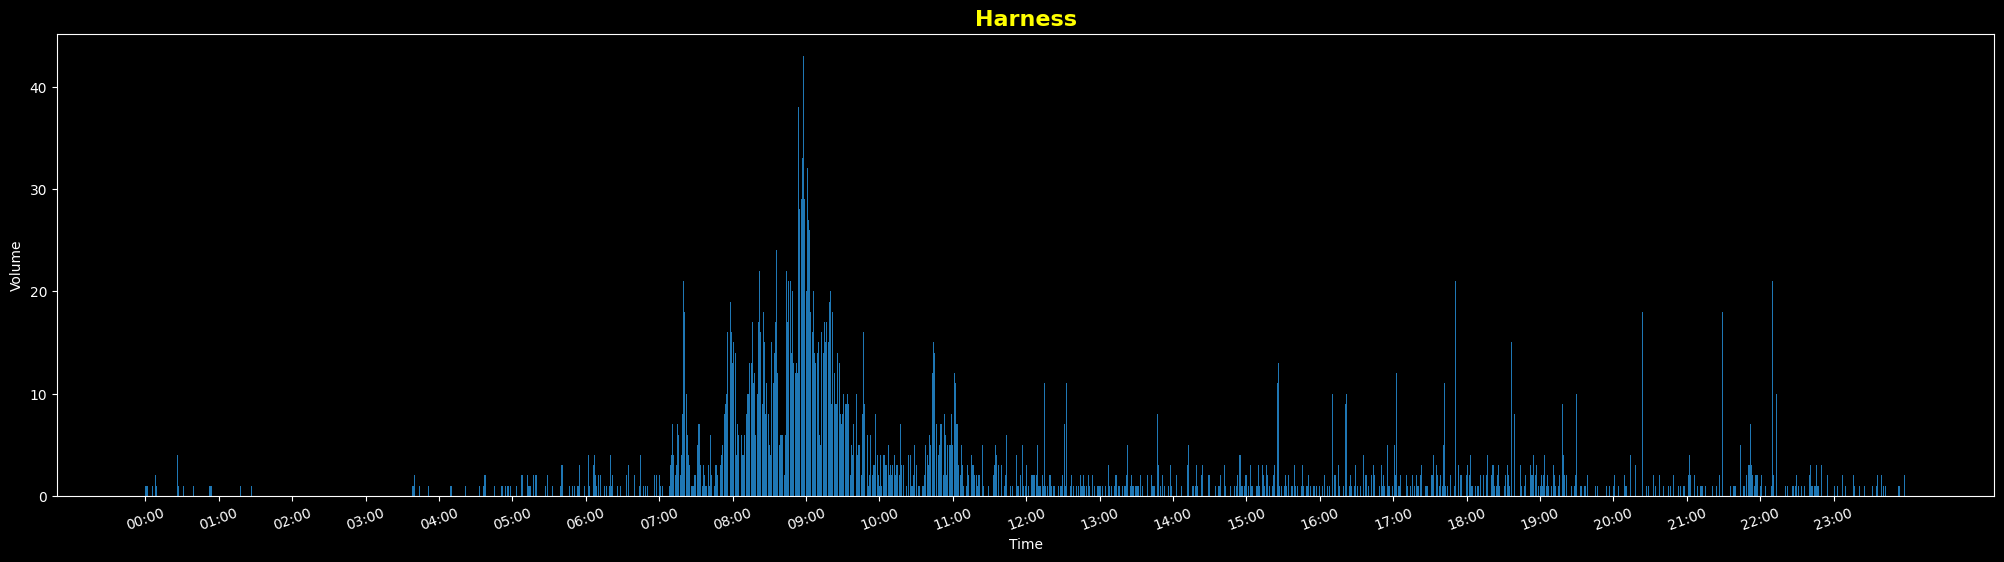

In [86]:
csv = r"C:\local\code\Betfair\work\scratchings\Removed_Runner_All.csv"
time_interval = "all"

# date intervals can be :
# all (aggregate per min)
# 15m (aggregate per 15 min)
# 1h (aggregate per hour)

main(csv, time_interval)